# Searching for Optimal Parameters for a Naive Superpixel Clustering Algorithm

Below is some code for finding the optimal configuration for a superpixel clustering algorithm based on SLIC and DBSCAN. The algorithm first performs SLIC (or SLIC-0) on the image to product a superpixel segmentation. Then it uses the DBSCAN clustering algorithm to merge superpixels based on average pixel similarity. This approach is naive and can be improved in a number of ways. It will serve as one of a few baselines against which we will compare our method.

In [1]:
import numpy as np
from skimage.segmentation import slic
from sklearn.cluster import DBSCAN

def method(img, kw_args):
    slic_kw_args = kw_args["slic"]
    dbscan_kw_args = kw_args["dbscan"]
    
    superpixels = slic(img, **slic_kw_args)
    sp_features = np.stack([
            img[superpixels == i].mean(axis=0)
            for i in np.unique(superpixels)
        ])
    sp_clusters = DBSCAN(**dbscan_kw_args).fit_predict(sp_features)
    segmentation = sp_clusters[superpixels]
    return segmentation

In [2]:
import dataset
imgs, anno = dataset.make_dataset(limit=10)

In [3]:
from sklearn.metrics import adjusted_rand_score

In [4]:
from functools import partial
import tqdm

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.matplotlib.rcParams["figure.figsize"] = [14, 8]

# Parameter Space

Both SLIC and DBSCAN have a number of parameters to tune that directly affect model output, described below:

- slic.compactness: trades off color-similarity and proximity
- slic.n_segments: the number of centers for kmeans
- dbscan.eps: maximum distance between two samples for them to be considered as in the same neighborhood
- dbscan.min_samples: number of samples (or total weight) in a neighborhood for a point to be considered as a core point

In [7]:
kw_args_space = {
    "slic": [
        {"slic_zero": True},
        {"compactness": 10., "n_segments": 10},
        {"compactness": 1., "n_segments": 10},
        {"compactness": .1, "n_segments": 10},
        {"compactness": .01, "n_segments": 10},
        {"compactness": 10., "n_segments": 50},
        {"compactness": 1., "n_segments": 50},
        {"compactness": .1, "n_segments": 50},
        {"compactness": .01, "n_segments": 50},
    ],
    "dbscan": [
        {"eps": 0.5, "min_samples": 5},
        {"eps": 0.1, "min_samples": 5},
        {"eps": 0.05, "min_samples": 5},
        {"eps": 0.01, "min_samples": 5},
        {"eps": 0.5, "min_samples": 25},
        {"eps": 0.1, "min_samples": 25},
        {"eps": 0.05, "min_samples": 25},
        {"eps": 0.01, "min_samples": 25},
    ],
}

In [8]:
import itertools as it

In [9]:
configs = it.product(kw_args_space["slic"], kw_args_space["dbscan"])
configs = map(lambda conf: zip(["slic", "dbscan"], conf), configs)
configs = map(dict, configs)
configs = list(configs)

In [10]:
scorer = lambda anno, pred: adjusted_rand_score(anno.flat, pred.flat)

In [11]:
scores = []
for config in tqdm.tqdm(configs):
    curr_method = partial(method, kw_args=config)
    preds = list(map(curr_method, imgs))
    config_scores = list(map(scorer, anno, preds))
    score = np.mean(config_scores)
    
    scores.append(score)

100%|██████████| 72/72 [04:34<00:00,  3.81s/it]


In [12]:
np.argmax(scores)

41

In [13]:
scores[41], configs[41]

(0.20463988513336445,
 {'dbscan': {'eps': 0.1, 'min_samples': 5},
  'slic': {'compactness': 10.0, 'n_segments': 50}})

# Results

Obviously the below segmentations are less than ideal... This is due to the limited number of images used during the parameter search as well as the limited scope of the parameter space. Both will be improved soon an a proper baseline will be established.

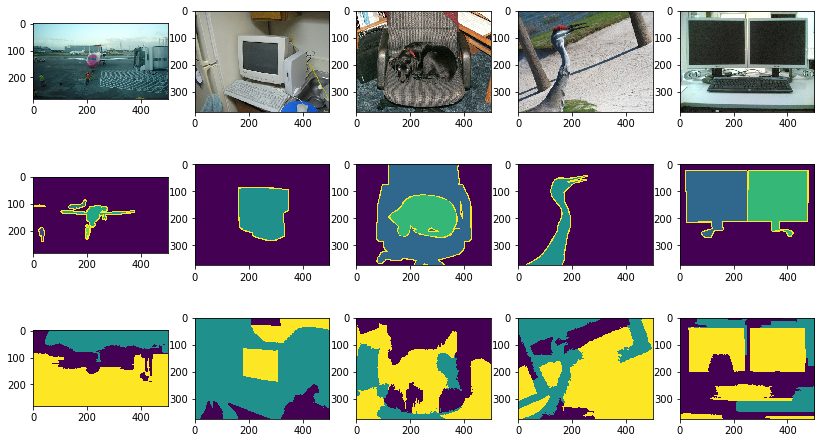

In [14]:
_, axs = plt.subplots(3, 5)
for img, ann, ax in zip(imgs, anno, axs.T):
    ax[0].imshow(img)
    ax[1].imshow(ann)
    ax[2].imshow(method(img, configs[41]))